# Fraud Detection: Voting Classifier Method

**Objective:**<br />

- In this notebook, I will implement all the functions required to build a Voting Classifier to predict fraud.

**After this code:**<br />

- I'll have a trained model to predict credit card fraud. For this voting classifier, I used 3 techniques :<br />
1. `LogisticRegression`
2. `RandomForestClassifier`
3. `DecisionTreeClassifier`

Let's get started!

## 1 - Packages

Let's first import all the packages that you will need during this code. 
- **pandas** is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.
- **numPy** is a Python library used for working with arrays. It also has functions for working in domain of linear algebra, fourier transform, and matrices.
- **itertools** is a module in python, it is used to iterate over data structures that can be stepped over using a for-loop. Such data structures are also known as iterables. This module incorporates functions that utilize computational resources efficiently.
- **matplotlib** is a comprehensive library for creating static, animated, and interactive visualizations in Python.
- **imbalanced-learn** is a python package offering a number of re-sampling techniques commonly used in datasets showing strong between-class imbalance.
- **scikit-learn** is a free machine learning library for Python.
- **math** provides access to the mathematical functions defined by the C standard.
- **sciPy** contains modules for optimization, linear algebra, integration, interpolation, special functions, FFT, signal and image processing, ODE solvers and other tasks common in science and engineering.

In [199]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from math import fabs
from scipy.stats import ks_2samp # Calcular o KS
from scipy import stats

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             precision_score,
                             recall_score,
                             roc_auc_score,
                             confusion_matrix,
                             classification_report)

## 2 - Import data

In [12]:
df = pd.read_csv(r'./src/creditcard_sampledata_3.csv',
                 sep=',',
                 decimal='.',
                 index_col=0,
                 engine='python')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5050 entries, 258647 to 63421
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      5050 non-null   float64
 1   V2      5050 non-null   float64
 2   V3      5050 non-null   float64
 3   V4      5050 non-null   float64
 4   V5      5050 non-null   float64
 5   V6      5050 non-null   float64
 6   V7      5050 non-null   float64
 7   V8      5050 non-null   float64
 8   V9      5050 non-null   float64
 9   V10     5050 non-null   float64
 10  V11     5050 non-null   float64
 11  V12     5050 non-null   float64
 12  V13     5050 non-null   float64
 13  V14     5050 non-null   float64
 14  V15     5050 non-null   float64
 15  V16     5050 non-null   float64
 16  V17     5050 non-null   float64
 17  V18     5050 non-null   float64
 18  V19     5050 non-null   float64
 19  V20     5050 non-null   float64
 20  V21     5050 non-null   float64
 21  V22     5050 non-null   float64

In [14]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
258647,1.725265,-1.337256,-1.012687,-0.361656,-1.431611,-1.098681,-0.842274,-0.026594,-0.032409,0.215113,...,0.414524,0.793434,0.028887,0.419421,-0.367529,-0.155634,-0.015768,0.010790,189.00,0
69263,0.683254,-1.681875,0.533349,-0.326064,-1.455603,0.101832,-0.520590,0.114036,-0.601760,0.444011,...,0.116898,-0.304605,-0.125547,0.244848,0.069163,-0.460712,-0.017068,0.063542,315.17,0
96552,1.067973,-0.656667,1.029738,0.253899,-1.172715,0.073232,-0.745771,0.249803,1.383057,-0.483771,...,-0.189315,-0.426743,0.079539,0.129692,0.002778,0.970498,-0.035056,0.017313,59.98,0
281898,0.119513,0.729275,-1.678879,-1.551408,3.128914,3.210632,0.356276,0.920374,-0.160589,-0.801748,...,-0.335825,-0.906171,0.108350,0.593062,-0.424303,0.164201,0.245881,0.071029,0.89,0
86917,1.271253,0.275694,0.159568,1.003096,-0.128535,-0.608730,0.088777,-0.145336,0.156047,0.022707,...,0.031958,0.123503,-0.174528,-0.147535,0.735909,-0.262270,0.015577,0.015955,6.53,0


In [15]:
df['Class'].value_counts()

0    5000
1      50
Name: Class, dtype: int64

In [17]:
# Verify that this is a case of class imbalance problem
ratio_cases = df['Class'].value_counts()/len(df.index)
print(f'Ratio of fraudulent cases: {ratio_cases[1]}\nRatio of non-fraudulent cases: {ratio_cases[0]}')

Ratio of fraudulent cases: 0.009900990099009901
Ratio of non-fraudulent cases: 0.9900990099009901


## 3 - Exploratory

In [64]:
# Define a function to create a scatter plot of our data and labels
def plot_data_df(df, var1, var2, target):
    plt.suptitle(f'Scatter Plot for {var1} and {var2}', size = 16);
    plt.scatter(df[df[target]==0][var1], df[df[target]==0][var2], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(df[df[target]==1][var1], df[df[target]==1][var2], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

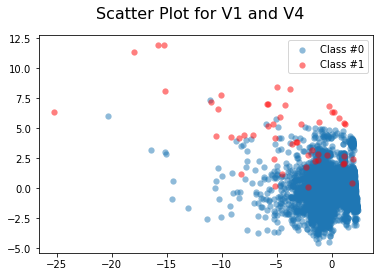

In [45]:
plot_data_df(df=df, var1='V1', var2='V4', target='Class')

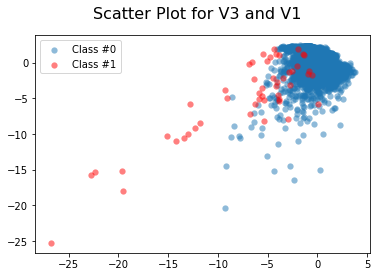

In [52]:
plot_data_df(df=df, var1='V3', var2='V1', target='Class')

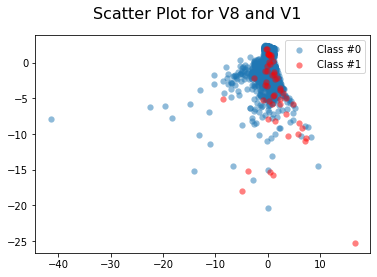

In [57]:
plot_data_df(df=df, var1='V8', var2='V1', target='Class')

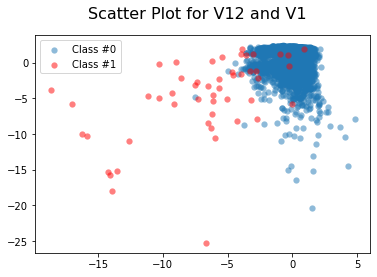

In [61]:
plot_data_df(df=df, var1='V12', var2='V1', target='Class')

## 4 - SMOTE

Synthetic Minority Oversampling Technique (SMOTE) is a resampling strategies for Imbalanced Data Sets. SMOTE uses characteristics of nearest neighbors of fraud cases to create new synthetic fraud cases. This strategy avoids duplicating observations.
**Important details for SMOTE**:
1. More sophisticated
2. Realistic data set
3. Training on synthetic data
4. <span style="color:red">Only works well if the minority case features are similar</span>. If fraud is spread through the data and not distinct, using nearest neighbors to create more fraud cases will just introduces noise into the data, as the nearest neighbors might not be fraud cases.

In [74]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X, y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

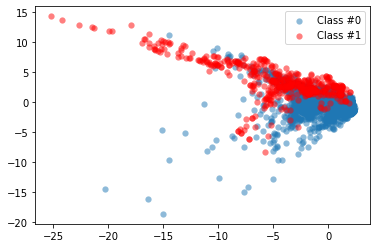

In [111]:
X = df.iloc[:, 0:29].values
y = df['Class'].values

# Define the resampling method
method = SMOTE(sampling_strategy=0.1, k_neighbors=12)

# Create the resampled feature set
X_resampled, y_resampled = method.fit_sample(X, y)

# Plot the resampled data
plot_data(X_resampled, y_resampled)

In [112]:
print('>>> Original data:')
display(pd.value_counts(pd.Series(y)))

print('>>> SMOTE data:')
display(pd.value_counts(pd.Series(y_resampled)))

>>> Original data:


0    5000
1      50
dtype: int64

>>> SMOTE data:


0    5000
1     500
dtype: int64

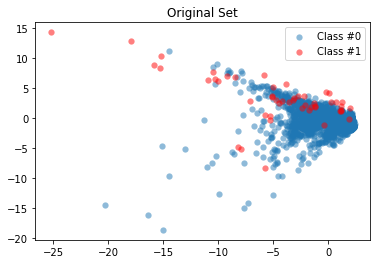

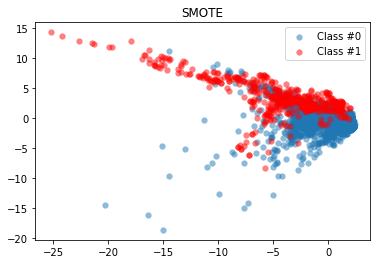

In [113]:
# Compare SMOTE to original data
plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
plt.title('Original Set')
plt.legend()
plt.show()
plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
plt.title('SMOTE')
plt.legend()
plt.show()

## 5 - Machine Learning

In [114]:
# Split my data X and y, into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [132]:
# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(class_weight={0:1, 1:15},
                          solver='liblinear',
                          random_state=5)
clf2 = RandomForestClassifier(class_weight={0:1, 1:12},
                              criterion='gini',
                              max_depth=8,
                              max_features='log2',
                              min_samples_leaf=10,
                              n_estimators=30,
                              n_jobs=-1,
                              random_state=5)
clf3 = DecisionTreeClassifier(random_state=5,
                              class_weight="balanced")
clf4 = GradientBoostingClassifier(random_state=5)

In [186]:
# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('gb', clf4)], voting='soft')

In [187]:
# Define the pipeline, tell it to combine SMOTE with the Voting Classifier model
pipeline = Pipeline([('SMOTE', SMOTE(sampling_strategy=0.1, k_neighbors=12)),
                     ('Voting Classifier', ensemble_model)])

In [188]:
# Fit my pipeline onto my training set and obtain predictions by fitting the model onto the test data 
pipeline.fit(X_train, y_train) 

pred = ensemble_model.predict(X_test)
prob = ensemble_model.predict_proba(X_test)[:, 0]

## 6 - Perfomance evaluation

In [189]:
# KS statistic
def calc_ks(y_test, prob):
    result = pd.DataFrame({'Target' : y_test, 'Score' : prob})
    return ks_2samp(result[result['Target'] == 0]['Score'], result[result['Target'] == 1]['Score'])[0]

# Percentile 5
def metric_caldesq(prob, y_test, perc):
    threshold = stats.scoreatpercentile(prob,perc)
    total_fraude = y_test.sum()
    tab1 = pd.DataFrame({"proba": prob, "y_real": y_test})
    total_fraude_5perc = tab1[(tab1["proba"] <= threshold)]["y_real"].sum()
    return total_fraude_5perc/total_fraude

# General Metrics
def MetricsAvaliation(y_test, y_pred, prob0, name):
    print('Sample size: {}'.format(len(y_test)))
    col_names =  ['Metric', name]
    my_df  = pd.DataFrame(columns = col_names)
    my_df = my_df.append(pd.DataFrame({"Metric": ["Accuracy"], name: accuracy_score(y_test, y_pred)}), ignore_index=True)
    my_df = my_df.append(pd.DataFrame({"Metric": ["KS"], name: calc_ks(y_test, prob0)}), ignore_index=True)                    
    my_df = my_df.append(pd.DataFrame({"Metric": ["Gini"], name: fabs((2*(roc_auc_score(y_test, prob0)))-1)}), ignore_index=True)
    my_df = my_df.append(pd.DataFrame({"Metric": ["AUC"], name: roc_auc_score(y_test, (1-prob0))}), ignore_index=True)
    my_df = my_df.append(pd.DataFrame({"Metric": ["F1-Score"], name: f1_score(y_test, y_pred, average='binary')}), ignore_index=True)
    my_df = my_df.append(pd.DataFrame({"Metric": ["Precision"], name: precision_score(y_test, y_pred, average='binary')}), ignore_index=True)
    my_df = my_df.append(pd.DataFrame({"Metric": ["Recall"], name: recall_score(y_test, y_pred, average='binary')}), ignore_index=True)
    my_df = my_df.append(pd.DataFrame({"Metric": ["P_01"], name: metric_caldesq(prob0, y_test, 1)}), ignore_index=True)
    my_df = my_df.append(pd.DataFrame({"Metric": ["P_02"], name: metric_caldesq(prob0, y_test, 2)}), ignore_index=True)
    my_df = my_df.append(pd.DataFrame({"Metric": ["P_03"], name: metric_caldesq(prob0, y_test, 3)}), ignore_index=True)
    my_df = my_df.append(pd.DataFrame({"Metric": ["P_04"], name: metric_caldesq(prob0, y_test, 4)}), ignore_index=True)
    my_df = my_df.append(pd.DataFrame({"Metric": ["P_05"], name: metric_caldesq(prob0, y_test, 5)}), ignore_index=True)
    my_df = my_df.append(pd.DataFrame({"Metric": ["P_20"], name: metric_caldesq(prob0, y_test, 20)}), ignore_index=True)
    my_df = my_df[col_names]
    return my_df

In [190]:
# Evaluate training set 
evaluation_train = MetricsAvaliation(
    y_train,
    ensemble_model.predict(X_train),
    ensemble_model.predict_proba(X_train)[:, 0],
    'Train_df')

Sample size: 4040


In [191]:
# Evaluate test set
evaluation_test = MetricsAvaliation(
    y_test,
    ensemble_model.predict(X_test),
    ensemble_model.predict_proba(X_test)[:, 0],
    'Test_df')

Sample size: 1010


In [192]:
# Join table 
evaluation_train.join(evaluation_test.set_index('Metric'), on='Metric')

,Metric,Train_df,Test_df
0,Accuracy,1.000000,0.999010
1,KS,1.000000,0.999004
2,Gini,1.000000,0.998672
3,AUC,1.000000,0.999336
4,F1-Score,1.000000,0.923077
5,Precision,1.000000,0.857143
6,Recall,1.000000,1.000000
7,P_01,0.931818,1.000000
8,P_02,1.000000,1.000000
9,P_03,1.000000,1.000000


In [194]:
# Print the classifcation report
print('Classification report:\n', classification_report(y_test, pred))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1004
           1       0.86      1.00      0.92         6

    accuracy                           1.00      1010
   macro avg       0.93      1.00      0.96      1010
weighted avg       1.00      1.00      1.00      1010



In [195]:
# Print the confusion matrix
def plot_confusion_matrix(cm, classes=['Not Fraud', 'Fraud'],
                          normalize=False,
                          title='Fraud Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-
        examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization


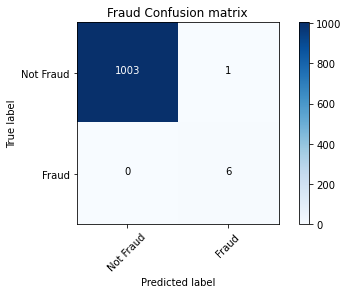

In [200]:
# Create a confusion matrix
km_cm = confusion_matrix(y_test, pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)

------------------